In [2]:
# let's train new models and test them on new datasets

In [1]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# let's load the dataset

df = pd.read_excel("./KSA_test.xlsx")

In [6]:
df.head()

,CPU Utilization
0,0.05273
1,0.04300
2,0.09000
3,0.13600
4,0.04545


In [5]:
df.drop('Response Time', inplace=True, axis=1)
df.drop('Class Name', inplace=True, axis=1)

In [7]:
# create train test split
train_length = round(len(df)*0.8)
test_length = len(df) - train_length
train = df.iloc[0:train_length]
test = df.iloc[train_length:]

In [8]:
# let's scale the values of the dataset
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [9]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - n_lags - 1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [10]:
TIME_STEPS = 50
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags=TIME_STEPS)
X_test, y_test = train_generator(test, n_lags=TIME_STEPS)

In [13]:
# let's build the lstm model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.LSTM(512, return_sequences=False))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 3,152,385
Trainable params: 3,152,385
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())

In [15]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [16]:
callbacks = [es, lr_red]
history = model.fit(X_train, y_train, epochs=100, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

Epoch 1/100
6/6 [==============================] - 12s 2s/step - loss: 0.1449 - val_loss: 0.0985 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 0.1075 - val_loss: 0.1179 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 0.1078 - val_loss: 0.0892 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 10s 2s/step - loss: 0.0909 - val_loss: 0.0875 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 10s 2s/step - loss: 0.0906 - val_loss: 0.0904 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 10s 2s/step - loss: 0.0893 - val_loss: 0.0852 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 10s 2s/step - loss: 0.0837 - val_loss: 0.0844 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 10s 2s/step - loss: 0.0833 - val_loss: 0.0840 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 10s 2s/step - loss: 0.0817 - val_loss: 0.0818 - lr: 0.0010
Epoch 10/1

dict_keys(['loss', 'val_loss', 'lr'])


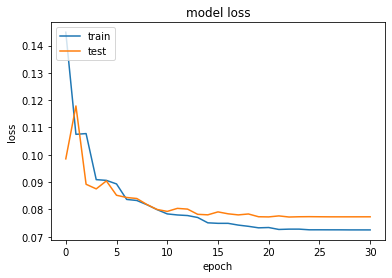

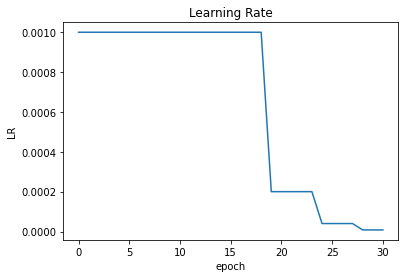

In [17]:
# try drawing the losses and the scores just to see where we are heading towards
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# why not also draw out the learning rate
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.ylabel('LR')
plt.xlabel('epoch')
plt.show()

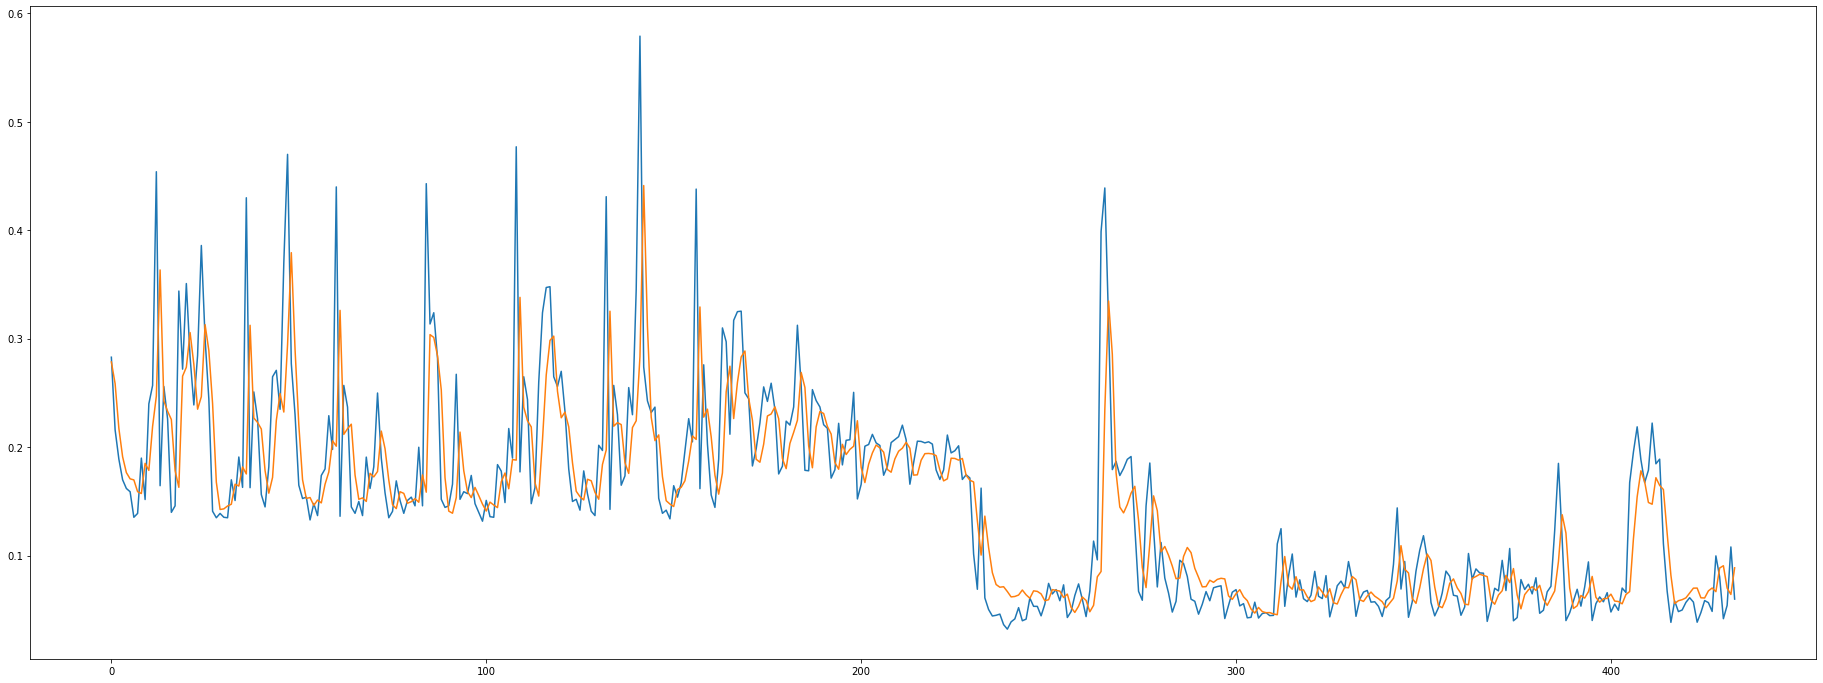

In [18]:
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(y_test)
PredY = pd.DataFrame(preds)

plot_max = plt.figure(1)
plt.plot(TestY)
plt.plot(PredY)
plt.show()

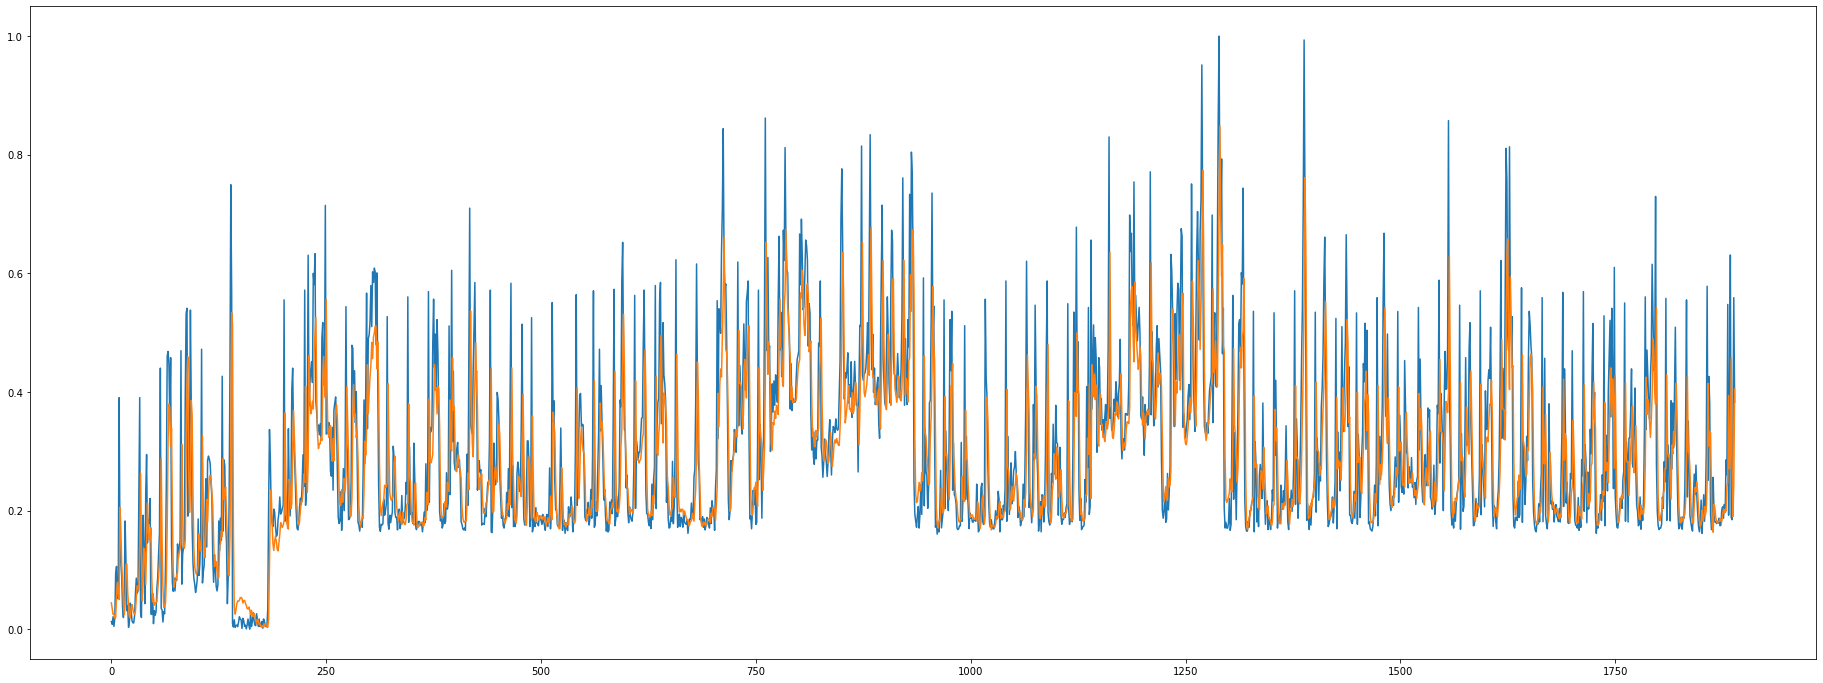

In [19]:
preds = model.predict(X_train)
#preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(y_train)
PredY = pd.DataFrame(preds)

plot_max = plt.figure(1)
plt.plot(TestY)
plt.plot(PredY)
plt.show()